# Ensemble Kalman Filter Workflow

1. Available observation vector for $\vec{y_{k+1}}$, and calculate the observation ensemble from the directional uncertainties based on the wind speed and direction. To calculate the uncertainty for each point of the perimeter:
    1. Obtain the centroid $c_k = 1/M\sum{y_k}$ where $M$ is the number of points.
    2. Calculate vectors $\vec{v_k^m}$ for each point from the centroid to the point where $m$ is the $m^{th}$ point in the perimeter
    3. Obtain the wind speed and direction: $\vec{u_k}$ from the closest weather station to the centroid
    4. Uncertainty for each point $m$ is then $e_k^m = \alpha \left(1 - \vec{v_k^m} \cdot \vec{u_k}\right)$

2. Given a state vector $x_k$ and uncertainties around each point $P_k$, generate an ensemble 
$$X_k = (x_k^1, x_k^2, \cdots , x_k^N)$$
    1. For the first timepoint $k=0$, the state vector is the first observation $(x_0 = y_0)$, and the ensemble is obtained from directional uncertainties assigned based on the wind speed and direction
    2. **Question:** When creating the ensemble, do we preserve the mean $\overline{x_k}$?
    
3. From the ensemble $X_k$, advance for each state vector $X_{k+1} = F(X_k, u_k)$, where $u_k$ 

4. 

## Dependencies:

In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

## Default Values

In [2]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [3]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = SELECTED_FIRE_DEFAULT
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


In [4]:
usr.db.gdfignition

,filetype,objectid,filepath,datetime,description,geometry
f23196b034474744bdca7df94b13e0f7,Ignition,21231,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 19:37:11,Maria2019,"POLYGON ((-2084217.148 1503560.461, -2084279.5..."
9f82e870591748a9a8a01346d174f2a1,Ignition,21232,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 19:58:22,Maria2019,"POLYGON ((-2082034.494 1504548.520, -2081987.6..."
1a6eb30ee33742e18fa6bb26678b5077,Ignition,21234,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 20:31:33,Maria2019,"POLYGON ((-2082034.494 1504548.520, -2081987.6..."
911f9b001c054b74a6ba70958f5f3c93,Ignition,21235,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 20:56:44,Maria2019,"POLYGON ((-2082396.219 1505343.939, -2082305.7..."
7957c2e604554199ba60c5b13aff2f40,Ignition,21236,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 21:22:55,Maria2019,"POLYGON ((-2082598.331 1505371.327, -2082338.5..."
714f0cf8d475462a97c651642a3d2525,Ignition,21237,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 23:31:00,Maria2019,"MULTIPOLYGON (((-2085055.250 1500983.797, -208..."
628d7730c0f149f898695d37a1350882,Ignition,21238,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-10-31 23:48:00,Maria2019,"POLYGON ((-2081520.701 1505276.095, -2081364.6..."
746e4f286cba4af4a89362b548f2c255,Ignition,21239,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 00:29:00,Maria2019,"POLYGON ((-2081508.646 1505341.661, -2081409.9..."
ec72de65d1934e0ab74ff46ffba1ae1b,Ignition,21240,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 00:54:00,Maria2019,"POLYGON ((-2081447.957 1505469.815, -2081376.9..."
15dc4b77768f4921be77c65ae9a6b9d4,Ignition,21241,/home/jovyan/farsite/inputs/maria_ignite/maria...,2019-11-01 01:12:00,Maria2019,"POLYGON ((-2081447.957 1505469.815, -2081376.9..."


In [5]:
referenceidx_lst = [usr.db.gdfignition.index[0]] + usr.db.gdfignition.index[-12:].tolist()

In [6]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]
    

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

In [41]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)


def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices)-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?

def create_ensembles(nsamples, current_state, windspeed, winddirection, normalized_scale, filetype, objectid, datetime, description):
                     
    # uncertainty in both x and y for each vertex
    # uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed*normalized_scale)*np.sqrt(current_state.lengths.sum())
    uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=1)

    ignitions = {'igniteidx': [], 
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'datetime': [],
                 'description': [],
                 'geometry': []}

    time_estimator = TimeEstimator(nsamples)
    for sample in range(nsamples):
        print(time_estimator.info_str(sample), end='\r', flush=True)
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}E{sample:04d}')

        geometry = sample_geometry(current_state, uncertainties)
        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
        
    return ignitions


def create_ensemble_matrix(geoms, vertex_count=100, aligned_geom=None):

    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2, nsamples))
    for i, vertices in enumerate(aligned_vertices):
        X[:,i] = vertices.flatten()
        
    return X, aligned_geom, vertex_count


def state_to_ignitions(X_0, objectid_lst, datetime_lst, description_lst, filetype_lst, usr):

    geoms = [Polygon(zip(X_0[::2,i], X_0[1::2,i])).buffer(0) for i in range(X_0.shape[1])]

    ignitions = {'igniteidx': [],
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'geometry': [],
                 'datetime': [],
                 'description': []}

    for sample, geometry in enumerate(geoms):
        filetype = filetype_lst[sample]
        datetime = datetime_lst[sample]
        description = description_lst[sample]
        objectid = objectid_lst[sample]
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}U{sample:04d}')

        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{description}U{sample:04d}_{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
    
    return ignitions

### Plotting functions

In [42]:
def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    ax.plot(X_mean[::2], X_mean[1::2], color=color)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

In [43]:
class EnKF:
    # Initialize with the first observation
    # Windspeed and direction is given from PyLaski
    def __init__(self, observation: gpd.GeoSeries, windspeed: int, winddirection: int, normalized_scale: float, nsamples: int, usr: futils.User):
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        
        
        self.state_datetime = observation['datetime']
        self.selected_fire = observation['description']
        self.igniteidx = observation.name
        self.current_state = State(state_geom)
        
        
        self.windspeed = windspeed
        self.winddirection = winddirection
        self.normalized_scale = normalized_scale
        self.nsamples = nsamples
        self.usr = usr

        self.ignitions = create_ensembles(self.nsamples, self.current_state, self.windspeed, self.winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])
        
        self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))
        
        # Create ensemble matrix
        self.X_0, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.ignitions['geometry'])
        
    # Updates the state matrix
    # Need to first add the observation into the database (usr.db for now)
    def update(self, compareidx: str, lcpidx: str, barrieridx: str, observation: gpd.GeoSeries, windspeed: int, winddirection: int):
        # Advance the state in Farsite using the windspeed and direction
        inputData_lst = []
        mainapi_lst = []
        for igniteidx in self.ignitions['igniteidx']:
            inputData = {'description': self.selected_fire,
                         'igniteidx'  : igniteidx,
                         'compareidx' : compareidx,
                         'lcpidx'     : lcpidx,
                         'barrieridx' : barrieridx,

                         'windspeed': windspeed, 'winddirection': winddirection,
                         'relhumid': 90, 'temperature': 20}

            mainapi_lst.append(self.usr.calculatePerimeters(inputData))
            

        # from multiprocessing import Pool

        # numproc = 4
        # pool = Pool(processes=numproc)

        # Run for each FarsiteManual
        for mainapi in mainapi_lst:
            # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
            mainapi.run_farsite()

        # pool.close()
        # pool.join()
        
        # Filter igniteidx->compareidx simulations only
        df = self.usr.db.gdfsimulation
        filtered_indices = df[df['igniteidx'].isin(self.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index
        
        self.Xt_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], 
                                                                                 self.vertex_count, self.aligned_geom)
        
        
        
        # Calculate ensemble for the observation
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        # igniteidx = observation.name
        state_datetime = observation['datetime']

        self.observed_state = State(state_geom)

        self.observed_ensemble = create_ensembles(self.nsamples, self.observed_state, windspeed, winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])

        self.Y_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.observed_ensemble['geometry'], self.vertex_count, self.aligned_geom)
        
        ##############################
        # Calculate the Kalman Filter
        ###############################
        self.Xt_1 = remove_duplicates(self.Xt_1, self.vertex_count)
        self.Y_1 = remove_duplicates(self.Y_1, self.vertex_count)

        xt_1 = self.Xt_1.mean(axis=1, keepdims=True)
        y_1 = self.Y_1.mean(axis=1, keepdims=True)

        Ex_1 = self.Xt_1 - xt_1.repeat(self.nsamples, axis=1)
        Ey_1 = self.Y_1 - y_1.repeat(self.nsamples, axis=1)

        Py_1 = 1/(nsamples-1)*np.matmul(Ey_1, Ey_1.T)
        Pxy_1 = 1/(nsamples-1)*np.matmul(Ex_1, Ey_1.T)

        max_Py = abs(Py_1).max()
        max_Pxy = abs(Pxy_1).max()

        Py_1 /= max_Py
        Pxy_1 /= max_Pxy

        Py_1inv = np.linalg.pinv(Py_1, hermitian=True)
            
        assert(np.allclose(np.matmul(Py_1inv, Py_1), np.eye(2*state.vertex_count))), 'Inverse calculation is incorrect'

        self.K = np.matmul(Pxy_1, Py_1inv)*(max_Pxy/max_Py)

        #### Update the state ensemble
        self.X_1 = state.Xt_1 + np.matmul(self.K, (self.Y_1 - self.Xt_1))        
        ####################
        # Recursive updates
        ##################
        
        # Update ignitions
        self.X_0 = self.X_1
        self.ignitions = state_to_ignitions(self.X_0, self.observed_ensemble['objectid'], self.observed_ensemble['datetime'], 
                           self.observed_ensemble['description'], self.observed_ensemble['filetype'], self.usr)
        
        self.current_state = self.observed_state
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition, gpd.GeoDataFrame(self.ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])
        
        # x_1 = X_1.mean(axis=1, keepdims=True)
        
# ## obtain the igniteidx of the ignition
# ## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
# compareidx = '9f82e870591748a9a8a01346d174f2a1'    # t=1 observation
# lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
# barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index        

In [44]:
def calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model):
    inputData = {'description': 'Maria2019',
                 'igniteidx'  : igniteidx_lst[-1],
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr_model.calculatePerimeters(inputData)
    mainapi.run_farsite()

    gdfsim = usr_model.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
    
    usr_model.db.gdfignition = pd.concat([usr_model.db.gdfignition, gpd.GeoDataFrame({'filetype': 'Ignition',
                                                                                      'objectid': str(usr_model.db.gdfignition.loc[gdfsim['igniteidx']]['objectid']) + '_farsite',
                                                                                      'filepath': gdfsim['filepath'],
                                                                                      'datetime': gdfsim['datetime'],
                                                                                      'description': gdfsim['description'],
                                                                                      'geometry': gdfsim_geom}, index=[gdfsim.name])
                                         ])
    igniteidx_lst.append(gdfsim.name)
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                     crs='EPSG:5070').to_file(gdfsim['filepath'])

In [45]:
def test_duplicates(arr):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                print(f'{i} found at pair {rix}, {rjx}')
            i += 1

def remove_duplicates(arr, dnumber):
    tst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):
            tst.append(arr[rix,:] - arr[rjx,:])

    tst = np.array(tst)
    tstsum = tst.sum(axis=1)
    zeroix = np.where(np.abs(tstsum) == 0)[0]

    i = 0
    rixlst = []
    rjxlst = []
    for rix in range(arr.shape[0]):
        for rjx in range(rix+1, arr.shape[0]):            
            if i in zeroix:
                # print(f'{i} found at pair {rix}, {rjx}')
                rixlst.append(rix)
                rjxlst.append(rjx)
            i += 1

    arrnew = np.zeros_like(arr)
    arr = np.delete(arr, rixlst, axis=0)

    for j in range(arr.shape[1]):
        vertices = list(zip(arr[::2,j], arr[1::2,j]))
        vertices_interpolated = interpolate_perimeter(vertices, dnumber)

        arrnew[:,j] = np.array(vertices_interpolated).flatten()

    return arrnew

In [46]:
# Initial params

initial = usr.db.gdfignition.iloc[0]
windspeed = 10   # Calculations are made with windspeed = 10, winddirection = 90
winddirection = 60
nsamples = 250
normalized_scale = 2

state = EnKF(initial, windspeed, winddirection, normalized_scale, nsamples, usr)
X_0_lst = [state.X_0]

usr_model = futils.User(fp)
# igniteidx_lst = ['f23196b034474744bdca7df94b13e0f7']
igniteidx_lst = [referenceidx_lst[0]]

/tmp/ipykernel_21736/2023211189.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))


Database interaction not yet implemented. Use pickle file for dataframes instead!


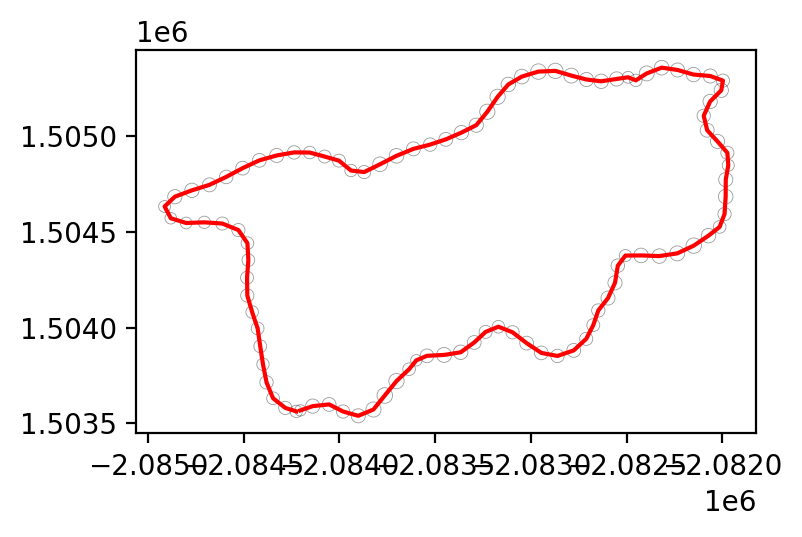

In [47]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
ax.set_aspect('equal')

### Testing EnKF update function

In [75]:
%%time

N = 100
sigma = 50

srange = np.arange(10,1001, 10)
detlst = []

time_estimator = TimeEstimator(len(srange))
for i, s in enumerate(srange):
    print(time_estimator.info_str(i), end='\r', flush=True)
    
    mat = np.random.randn(N,s)*50
    P_mat = np.matmul(mat, mat.T)/(nsamples-1)
    P_mat = P_mat/P_mat.max()
    
    detlst.append(np.linalg.det(P_mat))
# P_mat

CPU times: user 13.2 s, sys: 35.2 s, total: 48.4 s.   
Wall time: 12.2 s


/tmp/ipykernel_21736/2590402957.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticklabels(), color='red')


[Text(1, 1e-60, '$\\mathdefault{10^{-60}}$'),
 Text(1, 1e-50, '$\\mathdefault{10^{-50}}$'),
 Text(1, 1e-40, '$\\mathdefault{10^{-40}}$'),
 Text(1, 1e-30, '$\\mathdefault{10^{-30}}$'),
 Text(1, 1e-20, '$\\mathdefault{10^{-20}}$'),
 Text(1, 1e-10, '$\\mathdefault{10^{-10}}$'),
 Text(1, 1.0, '$\\mathdefault{10^{0}}$'),
 Text(1, 10000000000.0, '$\\mathdefault{10^{10}}$')]

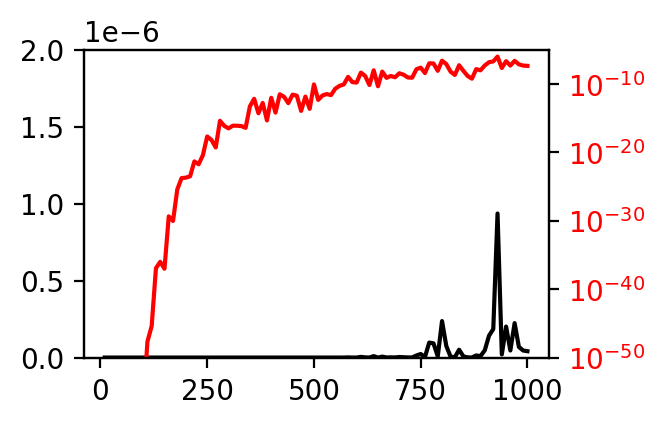

In [76]:
fig, ax = plt.subplots(1,1, figsize=(3,2), dpi=200)
ax.plot(srange, detlst, 'k')
ax.set_ylim(0, 2e-6)

ax2 = ax.twinx()

ax2.semilogy(srange, detlst, 'r')
ax2.set_ylim(1e-50, 1e-5)
ax2.set_yticklabels(ax2.get_yticklabels(), color='red')

In [26]:
np.matmul(np.linalg.pinv(P_mat, hermitian=True), P_mat)

array([[ 1.00000000e+00,  5.66828181e-14,  2.23043574e-12, ...,
        -6.71352211e-13, -6.38096944e-13, -2.21855128e-12],
       [ 3.46372560e-15,  1.00000000e+00,  9.70861787e-13, ...,
         4.71694100e-13, -1.54681854e-13, -8.73021085e-13],
       [-1.04715173e-13, -7.60085386e-13,  1.00000000e+00, ...,
         1.28508622e-13,  2.87958367e-13,  3.56037637e-13],
       ...,
       [-3.06427363e-13, -1.37991555e-12, -3.63640244e-13, ...,
         1.00000000e+00,  4.08736944e-13,  4.85147354e-13],
       [-5.37704883e-14, -2.85787727e-13,  6.26027730e-14, ...,
         1.14573126e-13,  1.00000000e+00, -2.89120428e-14],
       [ 5.68434189e-13,  7.67386155e-13,  1.08002496e-12, ...,
        -3.12258405e-13, -3.08652749e-14,  1.00000000e+00]])

### Test EnKF is done

In [48]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

# observation = usr.db.gdfignition.iloc[1]
observation = usr.db.gdfignition.loc[referenceidx_lst[1]]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

{'description': 'Maria2019', 'igniteidx': '967cdd65b41446f3a40877e130b52434', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'd19866c5b26a4a68b2b3771025032bd0', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '1571f50940a846fea2394c3d80cd1039', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04065/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed19866c5b26a4a68b2b3771025032bd0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04065/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04066/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1571f50940a846fea2394c3d80cd1039.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04066/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04067/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3ee2f272b41842c49b7989eaf16adab3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04067/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04068/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eae610db1db1a41538f4b433a436f5607.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04068/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04069/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E885c7446fb4449aa8c65e9641187cc85.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04069/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04070/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E948ec355b4144db4900dcf4ee1a86d00.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04070/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04071/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed72e41374bf7458c9c2163be7c647a99.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04071/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04072/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaa127ef571644741a428677f45342a22.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04072/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04073/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee118e68a98cb4a1f8c75e355f00a853c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04073/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04074/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8c16262364ad4a8da20924323f1db22b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04074/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04075/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef734e75759a3463a83671948154558a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04075/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04076/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8f0aaacce09e469a93da0a986c4bd14a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04076/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04077/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1667c57eba0b41da91ce084e23aa5f20.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04077/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04078/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2a1b92a568e84df4a0ba853d95e6e7ca.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04078/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04079/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb0576b1121584224999dc5c878afc63b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04079/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04080/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E095a4affd85b481abfb4c5df5f46f53a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04080/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04081/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea40e615e98c04de6aa1620cad1025c79.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04081/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04082/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E84b8c7b7ad944885b9f6feef51516b38.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04082/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04083/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7bf5bbc4dcd04e10aa0b526ecc0b408b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04083/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04084/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebe153487c9d74c31bfee1a601b0c17f6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04084/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04085/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecc269cca647643039114495be4932bc5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04085/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04086/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef9860c77f36344069bd97e4b45702999.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04086/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04087/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E731d9688a7b24a90b1234d39c72d3e7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04087/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04088/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edf24baf6b3c145f680a138090bda2e57.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04088/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04089/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E48f44003ddf74f48bb7f0a91fd3bfb67.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04089/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04090/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5f16f35dae63458d85bc039da09cb778.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04090/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04091/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2a2e461a192d41d9ad099c63583a4783.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04091/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04092/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E545f9a2f74da4f6db108ab8a39bcb61c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04092/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04093/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E70ec383d68ec4b42a3f79a283ba7eed4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04093/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04094/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edb676be228f84fb1a1b6caada5de8043.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04094/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04095/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E049e9875a77147e79f40031218ec153f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04095/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04096/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E11b18a8425d2490793a7c951acdc091b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04096/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04097/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2c9feac4d8414bbe925631034e53ccee.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04097/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04098/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E423a12017fef4112a6c35922e17004e3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04098/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04099/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9c73f07d0abe4b7f970fcf40c45f1e87.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04099/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04100/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb29a0ee96d034a98ac01db8a47b0a5df.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04100/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04101/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E978ce13b9b0642d3a241ec187d0ced01.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04101/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04102/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee96494e2c08e41928e41c07141ff5a19.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04102/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04103/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecd5914d17f3b42c7b6efda9993fe372b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04103/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04104/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E83e0f3bb63fd43af8191cb270255b859.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04104/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04105/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea28d632b2ff2420580b1e0084e40420e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04105/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04106/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1db9422230af42b7b17ce4e302e81c17.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04106/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04107/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8c6f5f2ddcd64e339fac955c8bb0781f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04107/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04108/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb46de684e77445b38c774852e0f6ac88.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04108/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04109/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E584ed994b5714bfaa84610c93d93f19b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04109/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04110/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5d6b957eaaee44fb8396adaa7721b6b5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04110/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04111/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E52ab27b210b842d5a7a6e6f6cc66bc83.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04111/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04112/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed821088bacc741eba7fce024b3ab26b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04112/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04113/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E24158db381c941189b253f8a4bb2ce19.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04113/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04114/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E54447972d6594491b1194c029ace86db.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04114/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04115/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E85b9f13749bc4cd0a29798a5dc95f074.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04115/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04116/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6e3f700b346243d7a309f117b88c5095.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04116/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04117/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecb7a727aafda4b2cbde26bb32822f96e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04117/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04118/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4ace0f46cf674393a2a48be92483dc03.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04118/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04119/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b19551ba49743b5b03512e8ab3bc6a0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04119/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04120/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7c19a05c59dd4899974e4eee6dee5d9c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04120/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04121/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efb0ac9f1b9044a1e91f2fc22d7a9e67c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04121/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04122/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea13f169e7abc4c7dbbc9a4585f2fad4a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04122/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04123/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4f5f8b40fea14abea6bbd1d5041a3b78.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04123/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04124/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3d82913aa4cb4f0a901a44fb08837b8c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04124/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04125/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0b1b8073d5394cb9b4a4e7f26cb928ad.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04125/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04126/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebf110ac5e6914146b3a5134835275fba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04126/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04127/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4fcd1d077fbc4809bde396477d244e68.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04127/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04128/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E20b2fd740ae145babc6637eb7a64dddf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04128/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04129/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2fc906315cbd46c5b3e51cfd82e05943.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04129/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04130/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0854a79c782c4ad79d968755ef03a8a2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04130/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04131/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6620588d02294aae92e595fc4ce5065f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04131/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04132/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2e06ef8233bd4e1fb809f9ffe0fcbcd7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04132/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04133/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec4d82ea6bd694adc8bc5720dafe50620.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04133/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04134/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E961da770f95843c1a00b221c0647a839.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04134/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04135/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E95ff9eb588154b509fb7be9ebc9eefc0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04135/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04136/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E76af49fc313b43c295dba0f746b3ba4f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04136/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04137/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7a22e4263ef24727816255109d82ac26.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04137/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04138/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3ccadd14589a4245b94eacc0cfcd6921.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04138/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04139/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E15c842d39420485384e383637a6a9145.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04139/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04140/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2e379929d02e4989b6ef8d92e4db16c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04140/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04141/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E45b666440b4f45acad508a97de39caf2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04141/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04142/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7675f22a1583437db2f9faf37d145419.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04142/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04143/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E78d208301e9344bb8e09aa6e11d474f1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04143/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04144/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7ce16cd577d6494fbd8f75436b7a5bfd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04144/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04145/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E43a64638bf1946b39b6b7a969f8fe5f4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04145/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04146/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E80ba7e73d4534de3b4ea028074364e1f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04146/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04147/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec2cdd05d3e6544b39e89126999dbffc3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04147/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04148/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E11d2d844c35c40f9b73d690575530228.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04148/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04149/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0580deff0c224ce592be0077c4ebd945.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04149/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04150/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebf078923493e4fcfb0d911f3dc71a51c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04150/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04151/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecfaf3a321de3480db762a73e3f44fceb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04151/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04152/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E71495f3d060c4adc92caa88bd545b4b9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04152/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04153/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E73a0db743cc54aaba3cf9a49e19fa6d0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04153/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04154/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebefc896a51714d51a0893760b03b8594.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04154/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04155/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed096a9b4806c4dc49cdc2ce5d57bb8ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04155/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04156/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee1435182ed694a6dbfbfef20df4113f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04156/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04157/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef4cf025a4fe1474aa8423e97ad4f14d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04157/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04158/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E430b63874f074b23b1e5947a96ac7b44.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04158/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04159/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E96f9441f063a457db4e22ae9deeb88ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04159/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04160/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E630f06a113f747088a29890ab39ef7b9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04160/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04161/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E646d3081c43244489367caf77d18712a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04161/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04162/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6c4e69b9cc5041b1be4ef2e98ab3bf2d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04162/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04163/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edd4bcbed89544626a72e5476fae3e09c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04163/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04164/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed09244e65139458e97de229ce716f133.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04164/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04165/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E18a9549eb5794efba36af8a3e16bc945.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04165/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04166/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6a5f339f71444ace81a570f9eb842d2f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04166/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04167/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec3ba7e13cd764ff09e5171e97582bce6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04167/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04168/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8cb400ee218740c58e8e05a83d58127f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04168/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04169/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2f586ac153c141be97ef22e0a9a0d70d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04169/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04170/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3a194ef9cec841c6a7588efa76aafa57.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04170/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04171/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E68f34461f7bc46fba41a73590a98da87.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04171/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04172/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb97897525e634eeea4881297e4b83aea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04172/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04173/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6d3522803a7c450c8e6ac9682d8c41df.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04173/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04174/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1535098a097740af8b3bde23623db1f8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04174/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04175/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E189393b0a1b4455e9c3becb8079c9ef7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04175/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04176/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4c68c9dd0d7941118ce2206c5bec1cce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04176/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04177/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed51f6c881ff94ed585aee27fbb10a4f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04177/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04178/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E46781c5e542f4e55ba35745a66be58a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04178/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04179/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8d14e50aedee44e99c7fd4f79818bc3c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04179/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04180/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee73220ccb52142e2b468cc25946cf189.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04180/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04181/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eae50f2a5d81046619defdfe3a7c68ada.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04181/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04182/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b3cc51899c44b05b6d6b1b1d4b634f3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04182/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04183/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eac05f284819f4c5eb22a4954076d554e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04183/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04184/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef0ed36ed580b421483e67ee08598443b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04184/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04185/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E45076094e3d549ec8ede88771980cf3c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04185/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04186/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea0f4fb16ecb54a69ab035650e7505311.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04186/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04187/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edfae5591b48940629614eed1a319f1fb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04187/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04188/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0bdb96de753c4a81bf45dbc434a71ec0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04188/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04189/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9db967eb8736450db02c1393c4463560.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04189/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04190/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0a95b0376bb1444798a712f1a2b47482.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04190/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04191/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E966ffe13c4704608a32a5f3317a11bb3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04191/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04192/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb982780afa36410e982e5b42e6554b34.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04192/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04193/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed0a4ad9d799b4f0385d0c9ba2779473c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04193/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04194/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E041405052fa34a7189684004b5736141.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04194/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04195/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaf408db59cd1437191ddc6e083d702b9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04195/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04196/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea2f204f206dd42a799665a21477734cb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04196/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04197/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E215115ba01d84f6ba5549e0b4c344efd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04197/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04198/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2635b20962c148b5bb5e79f7cf7b9cb0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04198/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04199/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eae5f41261e1c4cffa3f5c3fb8a98ab37.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04199/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04200/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eedb30fae418946c8bda0ee133a82d092.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04200/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04201/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee65551f1114c4ecdb83802827b7471e3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04201/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04202/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E666c0d6922c2466ca6440ae3dc19d9e1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04202/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04203/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6fef6310b9294be9bd408227906e9ef4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04203/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04204/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E488859e0659442779eaebf74059088cd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04204/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04205/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed29ebd53ac0f48738ec2b30ad8693a27.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04205/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04206/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4379a62b33324f9d81f95b802cc7a912.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04206/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04207/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec87317a1b3e5419fa4a8d2fd6f5c4924.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04207/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04208/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E67f116f390484b7c87fb850fd009bdf1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04208/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04209/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea825df2754664081840b3d563766d374.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04209/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04210/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee4cbe233e78344c0a0c6b038f7efd169.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04210/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04211/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E439d31353508449facf3f102f49e4d90.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04211/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04212/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1c139f416bc248739785b77258721193.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04212/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04213/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed773f55d951a4bfe9dd3366e097e5c8b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04213/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04214/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4806d18e4f1644bfb9f7c8d1a4e9d5cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04214/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04215/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E229b90671ea64f208c55e6e1bbf8aecf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04215/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04216/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecd524fbfed904f838566e122fcda50bf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04216/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04217/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edaed349b7f6041bd871e4342add9c1f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04217/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04218/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5446f12ee8c24bb09f4b501a8c5ede4f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04218/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04219/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E40c33d3674a84b1c8b4ae23c15990325.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04219/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04220/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E399404aa87fe4ab3b7cb0b2af5f99a51.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04220/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04221/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E23a45cb063f24c2c9d8a218b97eb86eb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04221/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04222/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8dee4318cb4247e8aa324ebb42936d91.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04222/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04223/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef377cec578f64ddab7a82e72dac6884b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04223/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04224/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5d72de2f9a7846abb72ae2582c655096.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04224/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04225/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee4a93466225c4c458ad8d1506acf2360.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04225/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04226/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb14d036c8a1d48f3a7a06c37637ccc45.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04226/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04227/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1905020d6df445adb0974a7d32aa5fc0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04227/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04228/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E32e8c4a1fe384260a5a5c30b9fe24da4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04228/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04229/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebd3be2d839e646179918ec817c3c5107.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04229/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04230/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E41e275400867446297dd195ba9af2608.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04230/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04231/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5e804c1052a948f197bdf2be2ded531a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04231/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04232/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E772cd2b8329a412181a754d405c3268c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04232/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04233/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaef456b249e74f858d5ae3325cd85b0a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04233/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04234/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E41f52bf52cf0428eb38621378d460a55.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04234/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04235/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E88d35a661e0d424895c80c49d1dcec6d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04235/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04236/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0b2828d802554a2cafa741afe0180ce9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04236/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04237/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5791051fbb754a4a8cc032258f0f72b2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04237/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04238/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E76bcd07f5c9a46299383c1a994aa763f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04238/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04239/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efb26fa7d8186441f9a25bd39c400a761.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04239/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04240/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E21d2c412872644908831d411cc69a2e5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04240/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04241/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebd280b8e670149d5a0a735bae58e9833.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04241/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04242/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eafa7ad791d314284bd008bb21fe77f6c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04242/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04243/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea7e4561f7c8d498cbd3e8fd8a69cfaab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04243/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04244/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E309b74ca2da74b3f96faf01dd2cf08b0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04244/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04245/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0b39fab53ed6435b8f56ec6ea15c64e6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04245/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04246/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E31d6e1f6e7534898bbcfab986e39e541.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04246/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04247/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E09de561bee85417595969749eb939231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04247/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04248/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed2965b41a3ad4d5c9afcfe97b576cd7e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04248/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04249/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E63158be54063457ea5f85171dc8351b5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04249/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04250/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eabf45dae9c2244beb32ea544ae9c6eb1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04250/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04251/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E872f3bb3e8fa47568fa3d2b76ca13783.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04251/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04252/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9bbdc453288a44008b956fbcd3fbbe98.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04252/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04253/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee8af9c4662164dc38394c956f159a050.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04253/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04254/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eed7eeee76ecf4dbcbbeda74dbfaccdd3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04254/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04255/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eed77c2ff02974f17910740693c2403f0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04255/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04256/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef3669cdfc0ff4ca6ad34bb54eb8eaa5b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04256/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04257/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef3f9a83ffb8446c390d78d6568f77f4d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04257/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04258/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2c9da871f10e4fe9abac533e3a8b8b33.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04258/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04259/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed9f6971579c34990b350f95805326ae1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04259/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04260/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea0d48cbbc26c4046ae8bc5278cdb9007.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04260/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04261/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee25c6b51cc314ddabd8f8eac2df2d6d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04261/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04262/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec4e0a7e82f384e0c955abd37a985fcfc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04262/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04263/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E23e5f8c2b80e49a6ae39467b1f878e20.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04263/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04264/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1d1c38af1abe478a9c0b3eb8175ca8c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04264/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04265/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec02d37371cb6451183793026bcd97de8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04265/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04266/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E39ed2411be4941acb3e6faa07724eb25.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04266/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04267/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecbdbe722e55f4a1c8fd2458e0ecf6032.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04267/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04268/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Efe1691492f0c4ad3b6bf2ba378fc8298.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04268/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04269/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2b4929f6389c4aa1941151386c394c46.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04269/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04270/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaa240e006e384a39a7cf9df244fa6cfd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04270/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04271/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecf827fe282804927974b7a7d27f3ce0b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04271/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04272/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E54638a506f9f45f9af154eef5e89f573.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04272/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04273/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea3994fdf10974483a826bac3a5c19009.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04273/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04274/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2866a3502c6148e9956e61c73bf2c1d0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04274/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04275/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edeb42124bbee4e5ab3532b742cd6c4a5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04275/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04276/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E16385144ed044b42b51decca93cb80bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04276/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04277/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E43ec44c0633d4665bdf5b8aac4d84cb6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04277/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04278/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E15580954d05e4eda9649dafe25bfe2dc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04278/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04279/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef6f1a5439c1145b998e5b7ffaeccbaea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04279/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04280/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef76ac1716eab42b592bd2828a9b8d540.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04280/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04281/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E39024c98da484504af73a0a5c616ae22.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04281/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04282/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E13170327d33441eeb8fd2216f0768c29.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04282/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04283/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E719b9429d8cb4509844fa194fe28f9f3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04283/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04284/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed616edec9ddf46eea56d0302088fcdf4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04284/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04285/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E14499c7678f845bd82f5619ff34e6509.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04285/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04286/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E459c6bc4a9e3430aaffb3b522c74eb6b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04286/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04287/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E75609a0dfb7b491cb420f23239ea32f7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04287/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04288/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed38223caebcc4abf9444fa8b214f08a2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04288/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04289/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8d89103c3dda4d76a8ac34c99ebf6278.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04289/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04290/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaa59bd85eb16414d8e9eea08bd16c014.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04290/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04291/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E12977ff810c64b9797bb1e2e26bdf25c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04291/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04292/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eaf72a1f705394d69a1e9dda72ce30a84.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04292/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04293/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef00611b939834647986f6b85f92268a4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04293/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04294/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed0164e63e14d4629a8c519beb2d6b475.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04294/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04295/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E98801387ce414dbe9018a0c97f988997.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04295/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04296/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E045edeb9a83d480a804c136f08fc538a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04296/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04297/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6087c4b4735c4c84bca74bb5ae8bc10b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04297/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04298/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E69b34c4471ca4a21a8999c595658a7d6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04298/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04299/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5c7ad6297b1f468591adea8e4c591427.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04299/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04300/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E89eaaa1613f04b828ad855597aeba1f8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04300/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04301/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E96de635a5c56427d873725b4bfc0a9e3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04301/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04302/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E07a961bea5ae4d75bf447d2ab530a454.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04302/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04303/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8bb73bdef70149b0bf704fddc0df5e50.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04303/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04304/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8ed14fcc6fba46e08c04cbaeec7924b7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04304/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04305/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3019fea184f94187822fd15ac8403cff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04305/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04306/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef92325d4769842c9aaaaab39e40411ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04306/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04307/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ece3c063d9ce4427383b220543cf41301.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04307/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04308/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E32924e1f24e84876b2ab912e70f30cf9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04308/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04309/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec9b8779df9ed44389270464c7ff4c78c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04309/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04310/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed18ae21a896b46b6ba2a978c3b8c1995.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04310/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04311/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb2e5bbb6c20044c39d210fe3d64af0bc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04311/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04312/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef07ae4a974314ff7970a7b33dfb196f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04312/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04313/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eab081ebd02424fc8beb1faa5d4b27f72.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04313/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 60, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 64).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230224/Run_04314/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230224/Run_04314/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [ ]:
state.X_0

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# plot_matrix(X_0_lst[0], ax=ax, color='red', show_stdev=True)
# ax.set_aspect('equal')

plt.plot(X_0_lst[0][::2, 0], X_0_lst[0][1::2, 0])
plt.plot(X_0_lst[0][50, 0], X_0_lst[0][51, 0], 'ro')

plt.plot(X_0_lst[0][::2, 50], X_0_lst[0][1::2, 50])
plt.plot(X_0_lst[0][50, 50], X_0_lst[0][51, 50], 'ko')

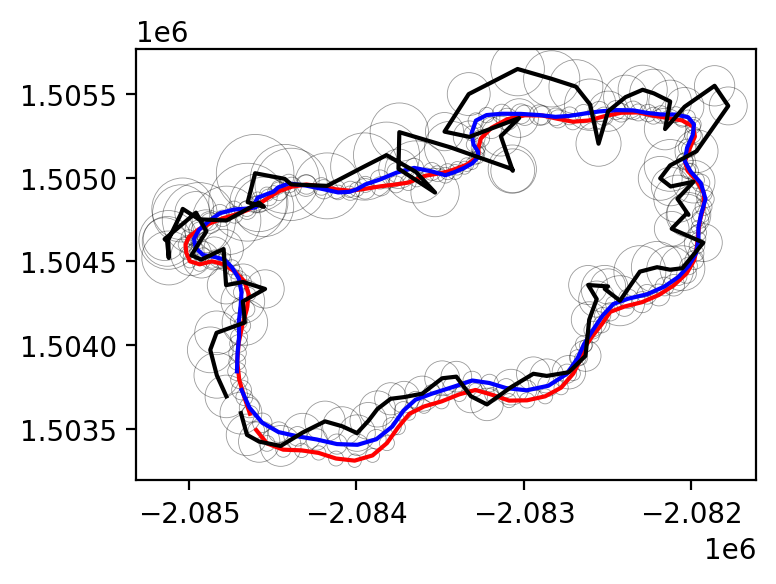

In [69]:
# # fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# # # plot_matrix(X_0_lst[0], ax=ax, color='red', ls='-')
# # plot_matrix(X_0_lst[1], ax=ax, show_stdev=True, color='blue', ls='--')
# # ax.set_aspect('equal')
# k = 1
# fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
# for i in [0,5,10,15,20,25,50]:
#     ax.plot(X_0_lst[k][::2, i], X_0_lst[k][1::2, i])

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_matrix(state.Xt_1, ax=ax, color='red', show_stdev=True)
# plot_matrix(X_0_lst[0], ax=ax, color='black', show_stdev=True)
plot_matrix(state.Y_1, ax=ax, color='blue', show_stdev=True)
plot_matrix(state.X_1, ax=ax, color='black', show_stdev=True)


ax.set_aspect('equal')

In [ ]:
%%time

calc_range = range(2,10)
time_estimator = TimeEstimator(len(calc_range))
for i in calc_range:
    print(time_estimator.info_str(i))
    observation = usr.db.gdfignition.iloc[i]
    compareidx = observation.name    # t=1 observation

    state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
    X_0_lst.append(state.X_0)

    calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    
igniteidx_lst_model = igniteidx_lst.copy()

In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file('/home/jovyan/data/ignitions/Maria2019U0081_f5421b23173641e18b5d780c6d528798.shp')
# gdf['geometry'][0]

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

# # plot_matrix(X_0_lst[0], ax)
# # plot_matrix(X_0_lst[1], ax, color='blue')
# plot_matrix(X_0_lst[0], ax, color='black')
# plot_matrix(X_0_lst[1], ax, color='black')
# plot_matrix(X_0_lst[2], ax, color='black')
# plot_matrix(X_0_lst[3], ax, color='black')
# plot_matrix(X_0_lst[4], ax, color='black')
# plot_matrix(X_0_lst[5], ax, color='black')
# plot_matrix(X_0_lst[6], ax, color='black')
# plot_geometry(usr.db.gdfignition.iloc[4]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[6]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[10]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[11]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[12]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[13]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[14]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[15]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[16]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[17]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[18]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[0]['geometry'], ax)

## Compare the predictions from the updated states, observations and using only the first simulation

### 1. Predict with the updated states

In [ ]:
usr_combined = futils.User(fp)
igniteidx_lst = []
compareidx_lst = []
for i, X_0 in enumerate(X_0_lst):
    obrow = usr.db.gdfignition.iloc[i]
    comprow = usr.db.gdfignition.iloc[i+1]
    
    vertices = X_0.mean(axis=1)
    geom = Polygon(zip(vertices[::2],vertices[1::2])).buffer(0)
    
    dt = obrow['datetime']
    desc = obrow['description']
    objid = str(obrow['objectid']) + '_updated'
    ftype = obrow['filetype']
    
    ignitions = state_to_ignitions(X_0.mean(axis=1, keepdims=True), [objid], [dt], [desc], [ftype], usr_combined)
    igniteidx_lst.append(ignitions['igniteidx'][0])
    compareidx_lst.append(comprow.name)
    
    usr_combined.db.gdfignition = pd.concat([usr_combined.db.gdfignition, gpd.GeoDataFrame(ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])

In [ ]:
igniteidx_lst_observed = []
compareidx_lst_observed = []
for i in range(len(igniteidx_lst)):
    igniteidx_lst_observed.append(usr_combined.db.gdfignition.index[i])
    compareidx_lst_observed.append(usr_combined.db.gdfignition.index[i+1])

In [ ]:
# Combine all igniteidx and compareidx into a single

igniteidx_lst_combined = igniteidx_lst + igniteidx_lst_observed
compareidx_lst_combined = compareidx_lst + compareidx_lst_observed

desc_lst_combined = ['Maria2019_updated' for i in range(len(igniteidx_lst))] + ['Maria2019_observed' for i in range(len(igniteidx_lst))]
inputData_lst = []
mainapi_lst = []
for (igniteidx, compareidx, desc) in zip(igniteidx_lst_combined, compareidx_lst_combined, desc_lst_combined):
    inputData = {'description': desc,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : '43b7f5db36994599861eec4849cc68fd',
                 'barrieridx' : 'cb47616cd2dc4ccc8fd523bd3a5064bb',
                 
                 'windspeed': 10, 'winddirection': 60,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr_combined.calculatePerimeters(inputData))
    
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

In [ ]:
# usr_combined.db.gdfignition.to_pickle('/home/jovyan/ignitions.pkl')
# usr_combined.db.gdfsimulation.to_pickle('/home/jovyan/simulations.pkl')

#### Interpolate all the vertices

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$

#### TODO - Question: Can we find a way to not interpolate the vertices
1. Without interpolation, we need to create a matrix that maps the observed vertices to the state vector

## Compare the perimeters

In [ ]:
# gdfignition = pd.read_pickle('/home/jovyan/ignitions.pkl')
# gdfsimulation = pd.read_pickle('/home/jovyan/simulations.pkl')

gdfignition = usr_combined.db.gdfignition
gdfsimulation = usr_combined.db.gdfsimulation

gdfignition_model = usr_model.db.gdfignition
gdfsimulation_model = usr_model.db.gdfsimulation

In [ ]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=2000)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

calculate_error = calculate_area_diff

In [ ]:
geoms_updated = []
geoms_observed = []
geoms_compare = []
geoms_model = []
errors_updated = []
errors_observed = []
errors_model = []
dt = []

for compareidx in compareidx_lst[:-1]:
    gdffiltered = gdfsimulation[gdfsimulation['compareidx'] == compareidx]
    
    geom_updated = gdffiltered[gdffiltered['description'] == 'Maria2019_updated']['geometry'].iloc[0]
    if isinstance(geom_updated, MultiPolygon):
        geom_updated = calculate_max_area_geom(geom_updated)
    geoms_updated.append(geom_updated)
    
    geom_observed = gdffiltered[gdffiltered['description'] == 'Maria2019_observed']['geometry'].iloc[0]
    if isinstance(geom_observed, MultiPolygon):
        geom_observed = calculate_max_area_geom(geom_observed)
    geoms_observed.append(geom_observed)
    
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    if isinstance(geom_compare, MultiPolygon):
        geom_compare = calculate_max_area_geom(geom_compare)
    geoms_compare.append(geom_compare)
    
    gdffiltered_model = gdfsimulation_model[gdfsimulation_model['compareidx'] == compareidx]
    geom_model = gdffiltered_model[gdffiltered_model['description'] == 'Maria2019']['geometry'].iloc[0]
    if isinstance(geom_model, MultiPolygon):
            geom_model = calculate_max_area_geom(geom_model)
    geoms_model.append(geom_model)
    
    dt.append((gdfignition.loc[compareidx, 'datetime'] - gdfignition.iloc[0]['datetime']).total_seconds()/60/60)
    
    errors_updated.append(calculate_error(geom_updated, geom_compare))
    errors_observed.append(calculate_error(geom_observed,  geom_compare))
    errors_model.append(calculate_error(geom_model, geom_compare))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=400)
ax.plot(dt, errors_updated, label='EnKF')
ax.plot(dt, errors_observed, label='Observed')
ax.plot(dt, errors_model, label='Model')

ax.set_xlim(0,6)
ax.set_ylim(0, 2.5e7)

ax.set_xlabel('Hours after first ignition')
ax.set_ylabel('Area difference')

ax.legend()